In [1]:
import sys
sys.path.append('../../')

In [5]:

from config.constants import *
from backtesting import Backtest, Strategy
from backtesting.test import EURUSD, SMA 
from backtesting.lib import plot_heatmaps, resample_apply
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from util.ATR import *
from util.SMA import *
from util.plot_return import *
from scipy.signal import argrelextrema

In [3]:
XAUUSD = {}
XAUUSD['H4'] = pd.read_csv(PATH_DATA + SYMBOL['XAUUSD']['H4'] + '.csv',index_col='Time',parse_dates=True)
XAUUSD['H1'] = pd.read_csv(PATH_DATA + SYMBOL['XAUUSD']['H1'] + '.csv', index_col='Time',parse_dates=True)

In [5]:
start_date = '2007-01-01'
end_date = '2008-01-01'

In [6]:
for i in TIMEFRAME :
    XAUUSD[i].index.name = None
    XAUUSD[i] = XAUUSD[i].loc[start_date:end_date]

In [4]:
XAUUSD['H4']

,Open,High,Low,Close,Volume
Time,,,,,
2007-01-01 00:00:00,635.679,636.194,635.009,635.497,95
2007-01-01 04:00:00,635.336,636.220,635.254,635.699,97
2007-01-01 08:00:00,635.780,636.225,635.201,635.993,99
2007-01-01 12:00:00,636.053,636.189,635.117,636.006,90
2007-01-01 16:00:00,635.902,636.185,635.006,635.989,96
...,...,...,...,...,...
2023-03-10 00:00:00,1831.428,1834.765,1827.974,1829.085,240
2023-03-10 04:00:00,1829.085,1834.575,1827.675,1833.405,240
2023-03-10 08:00:00,1833.415,1837.245,1830.778,1834.865,240


In [18]:
class Peak_levels(Strategy) :
    ATR_SL = 0.5
    entry_time = 8
    support = []
    resist = []
    def init(self):
        self.data.df['ATR'] = ATR(self.data.df, 20)['ATR']
        self.price = self.data.df['Close']

        self.minima_indices = argrelextrema(self.price.values, np.less_equal, order=100)[0]
        self.maxima_indices = argrelextrema(self.price.values, np.greater_equal, order=100)[0]

        self.data.df.loc[self.data.df.index[self.minima_indices],'min'] = self.price.iloc[self.minima_indices]
        self.data.df.loc[self.data.df.index[self.maxima_indices], 'max'] = self.price.iloc[self.maxima_indices]
        

    def next(self):

        if len(self.data.df) >= 12  :
            if (self.data.df['max'][-12] != None  and self.data.df['max'][-12] > 0):
                self.support.append(self.data.df['max'][-12])
            elif (self.data.df['min'][-12] != None and self.data.df['min'][-12]) > 0:
                self.resist.append(self.data.df['min'][-12])
      
        current_ATR = self.data.df.loc[self.data.df.index[-1], 'ATR']
        
        if not self.position and self.support != [] and any(self.data.df['Close'][-1] > s for s in self.support) and any(self.data.df['Close'][-1] <= s for s in self.support):
            tp = self.data.Close + current_ATR * self.ATR_SL * 5
            sl = self.data.Close - current_ATR * self.ATR_SL
            # Place your buy logic here
            self.buy(sl=sl, tp=tp, size=1)

        if not self.position and self.support != [] and any(self.data.df['Close'][-1] < s for s in self.resist) and any(self.data.df['Close'][-1] >= s for s in self.resist):
            tp = self.data.Close - current_ATR * self.ATR_SL * 5
            sl = self.data.Close + current_ATR * self.ATR_SL
               
            self.sell(sl=sl, tp=tp, size=1)

In [16]:
account_size = 20000

In [19]:
bt = Backtest(XAUUSD['H4'], Peak_levels, cash=account_size, margin=1/2000, )
result = bt.run()
result

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   89.571143
Equity Final [$]                 19340.812525
Equity Peak [$]                    20078.0491
Return [%]                          -3.295937
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                   -0.167334
Volatility (Ann.) [%]                0.508134
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -3.671854
Avg. Drawdown [%]                   -0.503506
Max. Drawdown Duration     4200 days 04:00:00
Avg. Drawdown Duration      439 days 17:00:00
# Trades                                17701
Win Rate [%]                          1.68917
Best Trade [%]                       4.932045
Worst Trade [%]                     -1.405693
Avg. Trade [%]                    

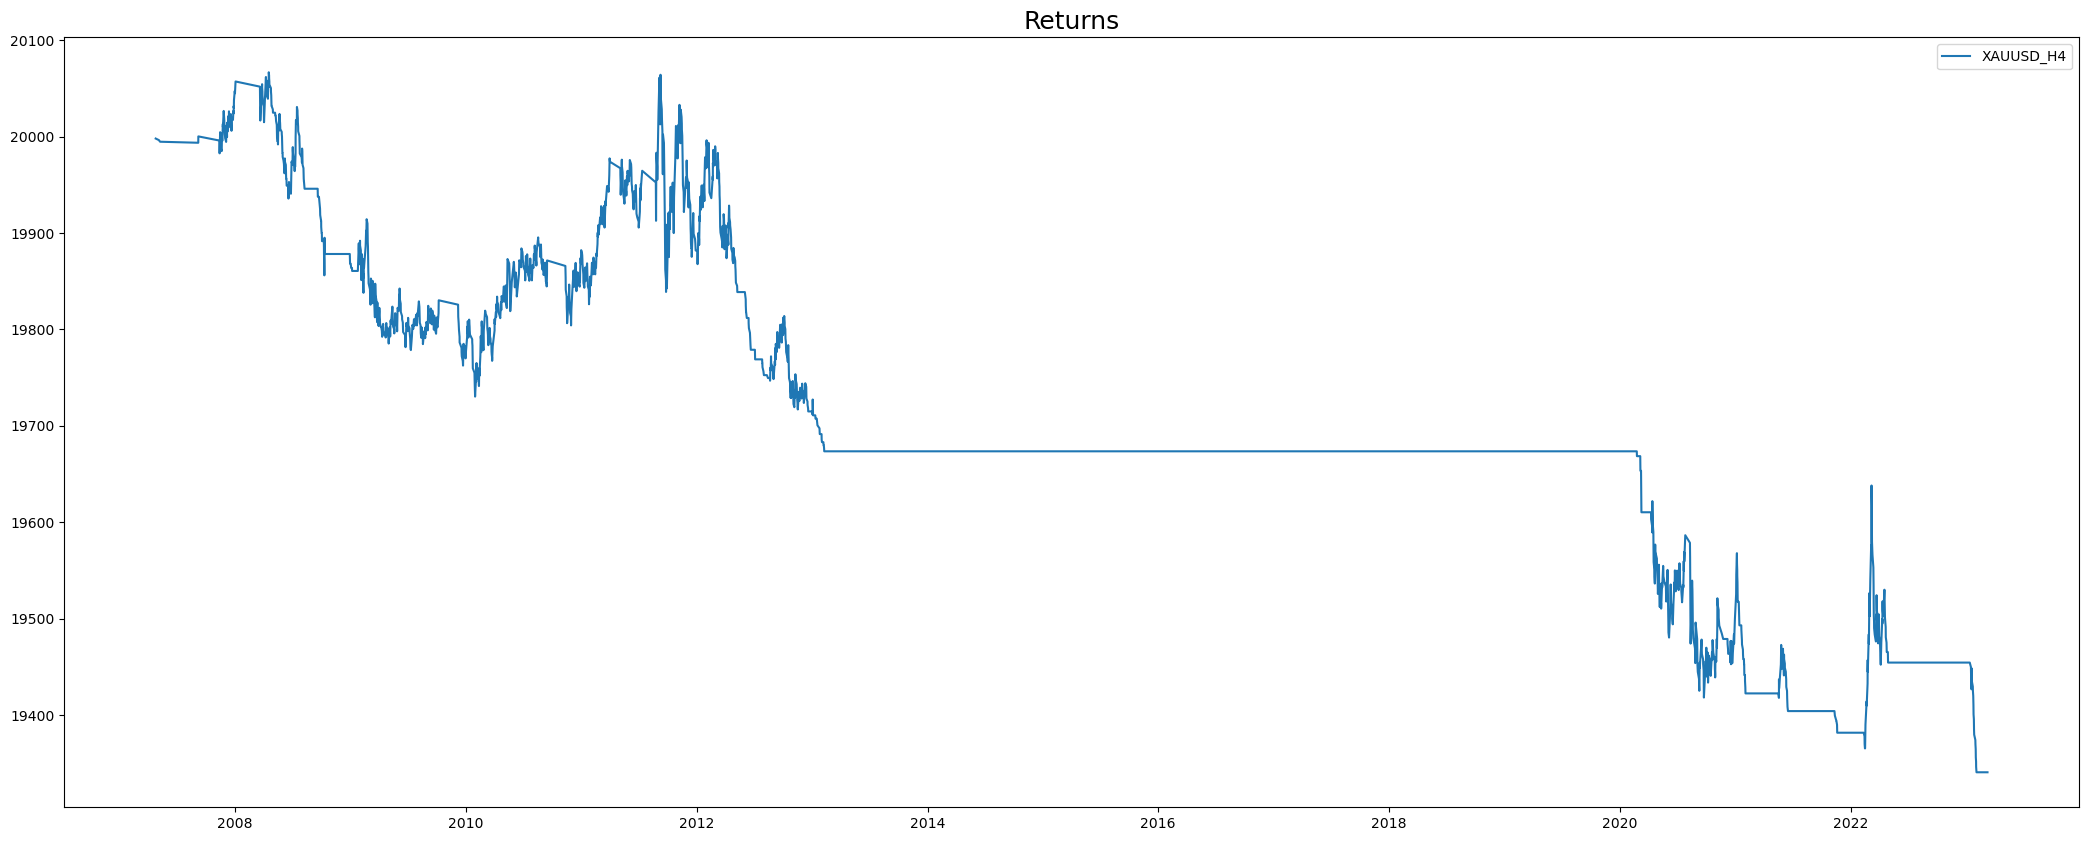

In [20]:
plot_return_trades(result['_trades'],'XAUUSD_H4' , account_size)

In [40]:
bt.plot()

c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_plotting.py:119: UserWarning: Data contains too many candlesticks to plot; downsampling to '1D'. See `Backtest.plot(resample=...)`
  warnings.warn(f"Data contains too many candlesticks to plot; downsampling to {freq!r}. "
c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_plotting.py:145: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  new_bar_idx = new_index.get_loc(mean_time, method='nearest')
c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_plotting.py:145: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  new_bar_idx = new_index.get_loc(mean_time, method='nearest')
c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_plotting.py:145: FutureWarning: Passing method to Int64Index.get_loc is deprecated and w

Row(id='3447', ...)